In [1]:
using Revise
using HighDimMixedModels

  ** incremental compilation may be fatally broken for this module **



In [2]:
using CSV
using DataFrames
using CategoricalArrays
print(pwd())
cog_df = CSV.read("src/data/cognitive.csv", DataFrame)
# form categorical variable for treatment
cog_df.treatment = categorical(cog_df.treatment, levels=["control", "calorie", "meat", "milk"]);

/Users/evangorstein/.julia/dev/HighDimMixedModels/docs

In [3]:
using StatsModels
f = @formula(ravens ~ 1 + year + treatment + sex + age_at_time0 +
                      height + weight + head_circ + ses + mom_read + mom_write + mom_edu)
model_frame = ModelFrame(f, cog_df)
model_mat = ModelMatrix(model_frame).m
X = model_mat[:, 1:2] # Features whose coefficients will not be penalized = covariates assigned random effects, in this case intercept and year
G = model_mat[:, 3:end]; # High dimensional covariates whose coefficients will be penalized

This is a random slopes model

In [4]:
using HighDimMixedModels
student_id = cog_df.id
y = cog_df.ravens
control = Control()
control.trace = 3
lasso = hdmm(X, G, y, student_id; control = control, penalty = "lasso")
scad = hdmm(X, G, y, student_id; control = control, penalty = "scad")

Cost at initialization: 3806.2338311170674
After updating fixed effects, cost is 3806.1858312138684
After updating fixed effects, cost is 3775.1895849610532
After updating fixed effects, cost is 3775.1819493536455
After updating fixed effects, cost is 3775.1816604153732
After updating fixed effects, cost is 3775.181657657033
After updating fixed effects, cost is 3775.1816575865973
Cost at initialization: 3806.2338311170674
After updating fixed effects, cost is 3806.6009806039506
After updating fixed effects, cost is 3775.3370478591023
After updating fixed effects, cost is 3775.3452602408283
After updating fixed effects, cost is 3775.345207159674
After updating fixed effects, cost is 3775.344998328392
After updating fixed effects, cost is 3775.340566820712
After updating fixed effects, cost is 3775.331800043164
After updating fixed effects, cost is 3775.3305555697375
After updating fixed effects, cost is 3775.330466831559


HDMModel fit with 1562 observations
Log-likelihood at convergence: -3770.4
Random effect covariance matrix:
2×2 Matrix{Float64}:
 2.1428  0.0
 0.0     0.331256
Estimated 7 non-zero fixed effects:
────────────────
        Estimate
────────────────
1    8.37725
2    1.07694
4    0.188756
5   -0.120542
10   0.174951
11   0.000466143
13   0.017775
────────────────
Estimated σ²: 5.7654


In [7]:
scad.init_coef.βstart

14-element Vector{Float64}:
 18.088988476312394
  0.7388250911102892
  0.0
  0.12089870115907989
 -0.07825650818901153
 -0.017134150206900574
  0.0
  0.0
  0.0
  0.22309332940474655
  0.04717574786879623
  0.0
  0.1275521242041264
  0.0

In [11]:
coeftable(scad, coefnames(model_frame)) |> println
println(scad.σ²)
display(scad.L)
using Statistics
var(residuals(scad))

─────────────────────────────
                     Estimate
─────────────────────────────
(Intercept)       8.37725
year              1.07694
treatment: meat   0.188756
treatment: milk  -0.120542
head_circ         0.174951
ses               0.000466143
mom_write         0.017775
─────────────────────────────
5.765442693167185


2×2 Matrix{Float64}:
 1.46383  0.0
 0.0      0.575548

4.838184310510893

In [10]:
println(coeftable(lasso, coefnames(model_frame)))
println(lasso.σ²)
using Statistics
var(lasso.resid)

─────────────────────────────
                     Estimate
─────────────────────────────
(Intercept)      10.3316
year              1.07736
treatment: meat   0.182962
treatment: milk  -0.131185
head_circ         0.135895
ses               0.000776817
mom_write         0.0173257
─────────────────────────────
5.765834434301348


4.83774485191753

In [12]:
show(stdout, "text/plain", scad.ψ)
show(stdout, "text/plain", lasso.ψ)

2×2 Matrix{Float64}:
 2.1428  0.0
 0.0     0.3312562×2 Matrix{Float64}:
 2.14976  0.0
 0.0      0.330828

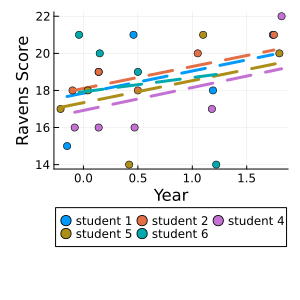

In [82]:
mask = student_id .== 1
plot(cog_df.year[mask], cog_df.ravens[mask], seriestype = :scatter, label = "student 1", color = 1 )
plot!(cog_df.year[mask], fitted(scad)[mask], seriestype = :line, color = 1, linestyle = :dash, linewidth = 3, label = "")
for i in [2,4,5,6]
    mask = student_id .== i
    # add student to plot
    plot!(cog_df.year[mask], cog_df.ravens[mask], seriestype = :scatter, label = "student $i", color = i)
    plot!(cog_df.year[mask], fitted(scad)[mask], seriestype = :line, color = i, linestyle = :dash, linewidth = 3, label = "")
end
plot!(size = (300, 300), legend=:outerbottom, legendcolumns=3, xlabel = "Year", ylabel = "Ravens Score")

In [45]:
[student x ravens_true ravens_pred]  

20×4 Matrix{Float64}:
 1.0  -0.15  15.0  17.6767
 1.0   0.14  19.0  18.0234
 1.0   0.46  21.0  18.406
 1.0   1.19  18.0  19.2788
 1.0   1.74  21.0  19.9363
 2.0  -0.1   18.0  17.985
 2.0   0.14  19.0  18.2694
 2.0   0.5   18.0  18.696
 2.0   1.05  20.0  19.3478
 2.0   1.75  21.0  20.1774
 4.0  -0.08  16.0  16.7979
 4.0   0.14  16.0  17.0703
 4.0   0.47  16.0  17.4788
 4.0   1.18  17.0  18.358
 4.0   1.82  22.0  19.1504
 5.0  -0.21  17.0  17.0889
 5.0   0.04  18.0  17.3863
 5.0   0.42  14.0  17.8383
 5.0   1.1   21.0  18.6472
 5.0   1.8   20.0  19.4799

In [ ]:
linetypes = [:path :steppre :steppost :sticks :scatter]
n = length(linetypes)
x = map((_->begin
                sort(rand(20))
            end), 1:n)
y = rand(20, n)
plot(x, y, line = (linetypes, 3), lab = map(string, linetypes), ms = 15)